In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import subprocess

In [ ]:
## Function to find event files/lc files from the directory 
def find_event_files(base_directory):
    event_files = []
    
    # Regular expression to match the pattern ObsID/xti/event_cl/
    obsid_pattern = re.compile(r'^\d{10}$')
    
    # Regular expressions to match the specific filename patterns
    file_pattern = re.compile(r'^ni\d{10}_0mpu7_cl_(night|daynotconsidered)_barycorr_orbit_piexpiex_yes.evt$')

    for obsid_dir in os.listdir(base_directory):
        obsid_path = os.path.join(base_directory, obsid_dir)

        # Check if it's a directory and matches the 10-digit ObsID pattern
        if os.path.isdir(obsid_path) and obsid_pattern.match(obsid_dir):
            #print(f"Found 10-digit ObsID folder: {obsid_dir}")

            # Look for files in this directory matching the .evt pattern
            for file in os.listdir(obsid_path):
                if file_pattern.match(file):
                    full_path = os.path.join(obsid_path, file)
                    event_files.append(full_path)
                    # print(f"Found .evt file: {full_path}")

    return event_files

In [ ]:
## Write a code to extract the spin period from the txt file using Obs ID as primary key

## Convert spin period to frequency for phase formula. 

In [85]:
base_directory='./reduced_output'

test_input="/home/supremekai/thesis/J0243_6p6124/nicer/reduced_output/6050390231/ni6050390231_0mpu7_cl_night_barycorr_orbit_piexpiex_yes.evt"
test_output="/home/supremekai/thesis/J0243_6p6124/nicer/reduced_output/6050390231/ni6050390231_0mpu7_cl_night_barycorr_orbit_piexpiex_yes_trial_phase_resolved_test.evt"

#Running the code to find event files
first_input_orbit_file_list=find_event_files(base_directory)
print("Total number of input event files found: ",len(first_input_orbit_file_list))
for first_input_file in first_input_orbit_file_list:
    print("*******Adding Orbit Time from common reference******")
    print("Working on the file: ",first_input_file)
    print(first_input_file.split("/")[2])
    first_output_file = first_input_file.replace(".evt", "_phase_added.evt")
    first_ftcalc_command=f'ftcalc infile={first_input_file+"[events]"} outfile={first_output_file} column=ORBIT_REF_TIME expression="(ORBITTIME-(303782402.000))" clobber=yes'
    try:
        subprocess.run(first_ftcalc_command,shell=True, check=True)
        print("Successfully saved as: ",first_output_file)
    except subprocess.CalledProcessError as e:
        print(f"Error processing {first_input_file}: {e}")
    

    print("*******Adding Phase column in same file******")
    second_input_file=first_output_file
    second_output_file=first_output_file
    second_ftcalc_command=f'ftcalc infile={second_input_file+"[events]"} outfile={second_output_file} column=PHASE expression="(0.1021189686*(ORBIT_REF_TIME))%1" clobber=YES'                 
    
    try:
        subprocess.run(second_ftcalc_command,shell=True, check=True)
        print("Successfully saved as: ",second_output_file)
    except subprocess.CalledProcessError as e:
        print(f"Error processing {first_input_file}: {e}")
    break



Total number of input event files found:  67
*******Adding Orbit Time from common reference******
Working on the file:  ./reduced_output/6050390261/ni6050390261_0mpu7_cl_night_barycorr_orbit_piexpiex_yes.evt
6050390261
Successfully saved as:  ./reduced_output/6050390261/ni6050390261_0mpu7_cl_night_barycorr_orbit_piexpiex_yes_phase_added.evt
*******Adding Phase column in same file******
Successfully saved as:  ./reduced_output/6050390261/ni6050390261_0mpu7_cl_night_barycorr_orbit_piexpiex_yes_phase_added.evt


In [86]:
hdul=fits.open('./reduced_output/6050390261/ni6050390261_0mpu7_cl_night_barycorr_orbit_piexpiex_yes_phase_added.evt')

hdul.info()

Filename: ./reduced_output/6050390261/ni6050390261_0mpu7_cl_night_barycorr_orbit_piexpiex_yes_phase_added.evt
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      32   ()      
  1  EVENTS        1 BinTableHDU    443   1013196R x 18C   [1D, 1B, 1B, 1I, 1I, 1B, 1B, 8X, 1K, I, J, 1I, 1I, 1E, 1D, 1D, 1D, 1D]   
  2  FPM_SEL       1 BinTableHDU    128   2387R x 3C   [1D, 56B, 56I]   
  3  GTI           1 BinTableHDU    258   3R x 2C   [D, D]   
  4  GTI_MPU0      1 BinTableHDU    257   3R x 2C   [D, D]   
  5  GTI_MPU1      1 BinTableHDU    257   3R x 2C   [D, D]   
  6  GTI_MPU2      1 BinTableHDU    257   3R x 2C   [D, D]   
  7  GTI_MPU3      1 BinTableHDU    257   3R x 2C   [D, D]   
  8  GTI_MPU4      1 BinTableHDU    257   3R x 2C   [D, D]   
  9  GTI_MPU5      1 BinTableHDU    257   3R x 2C   [D, D]   
 10  GTI_MPU6      1 BinTableHDU    257   3R x 2C   [D, D]   


In [87]:
events=hdul[1]

In [88]:
events.columns

ColDefs(
    name = 'TIME'; format = '1D'; unit = 's'; disp = 'F20.9'
    name = 'RAWX'; format = '1B'; unit = 'pixel'; coord_type = 'RAWX'; coord_ref_point = 0; coord_ref_value = 0.0; coord_inc = 1.0
    name = 'RAWY'; format = '1B'; unit = 'pixel'; coord_type = 'RAWY'; coord_ref_point = 0; coord_ref_value = 0.0; coord_inc = 1.0
    name = 'PHA'; format = '1I'; unit = 'chan'; null = -32768
    name = 'PHA_FAST'; format = '1I'; unit = 'chan'; null = -32768
    name = 'DET_ID'; format = '1B'; disp = 'I2.2'
    name = 'DEADTIME'; format = '1B'; unit = 's'; bscale = 6.202e-07; bzero = 3.101e-07; disp = 'F11.9'
    name = 'EVENT_FLAGS'; format = '8X'
    name = 'TICK'; format = '1K'
    name = 'MPU_A_TEMP'; format = 'I'; unit = 'Celsius'; null = -1; bscale = 0.10600843; bzero = -273.42105; disp = 'F6.3'
    name = 'MPU_UNDER_COUNT'; format = 'J'; null = -1
    name = 'PI_FAST'; format = '1I'; unit = 'chan'; null = -32768
    name = 'PI'; format = '1I'; unit = 'chan'; null = -32768
    name

In [89]:
phase=events.data['PHASE']

In [90]:
phase.size

1013196

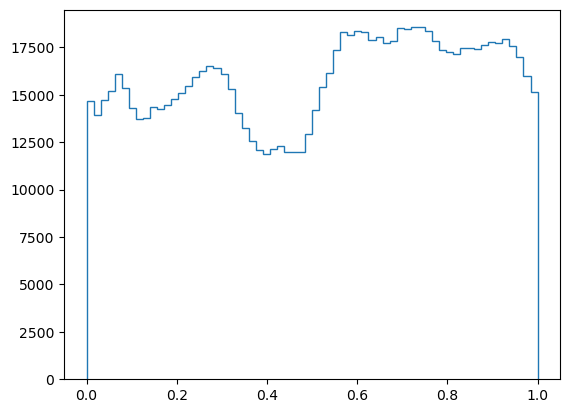

In [96]:
listed=plt.hist(phase,bins=64,histtype='step')
# plt.ylim(13000)

In [97]:
len(listed[1]),len(listed[0])

(65, 64)

In [98]:
listed[1]

array([2.96686267e-07, 1.56252799e-02, 3.12502632e-02, 4.68752464e-02,
       6.25002296e-02, 7.81252129e-02, 9.37501961e-02, 1.09375179e-01,
       1.25000163e-01, 1.40625146e-01, 1.56250129e-01, 1.71875112e-01,
       1.87500096e-01, 2.03125079e-01, 2.18750062e-01, 2.34375045e-01,
       2.50000028e-01, 2.65625012e-01, 2.81249995e-01, 2.96874978e-01,
       3.12499961e-01, 3.28124945e-01, 3.43749928e-01, 3.59374911e-01,
       3.74999894e-01, 3.90624878e-01, 4.06249861e-01, 4.21874844e-01,
       4.37499827e-01, 4.53124811e-01, 4.68749794e-01, 4.84374777e-01,
       4.99999760e-01, 5.15624744e-01, 5.31249727e-01, 5.46874710e-01,
       5.62499693e-01, 5.78124676e-01, 5.93749660e-01, 6.09374643e-01,
       6.24999626e-01, 6.40624609e-01, 6.56249593e-01, 6.71874576e-01,
       6.87499559e-01, 7.03124542e-01, 7.18749526e-01, 7.34374509e-01,
       7.49999492e-01, 7.65624475e-01, 7.81249459e-01, 7.96874442e-01,
       8.12499425e-01, 8.28124408e-01, 8.43749392e-01, 8.59374375e-01,
      

In [99]:
listed[0]

array([14662., 13942., 14748., 15205., 16103., 15376., 14327., 13746.,
       13785., 14364., 14252., 14462., 14803., 15112., 15470., 15951.,
       16246., 16524., 16429., 16092., 15302., 14042., 13270., 12557.,
       12082., 11900., 12141., 12303., 12007., 11980., 11981., 12960.,
       14221., 15404., 16174., 17347., 18305., 18179., 18342., 18317.,
       17885., 18034., 17739., 17844., 18544., 18495., 18563., 18559.,
       18365., 17852., 17382., 17235., 17163., 17467., 17463., 17398.,
       17654., 17762., 17712., 17971., 17555., 17003., 15969., 15169.])

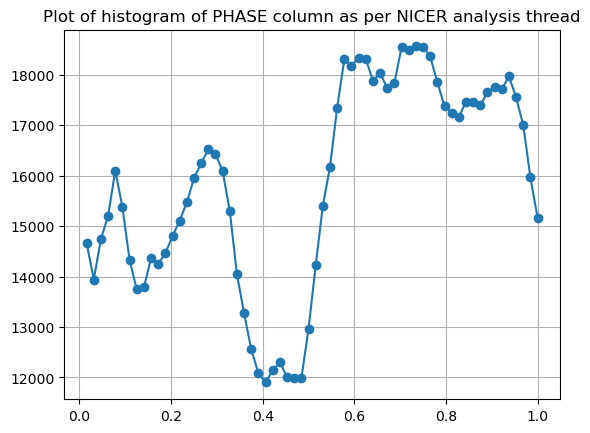

In [102]:
### Plot the profile as a line plot
plt.plot(listed[1][1:],listed[0],'-o')
plt.title("Plot of histogram of PHASE column as per NICER analysis thread")
plt.grid()

In [103]:
folded_fits=fits.open("./folded_curves/6050390261/phase_resolved_flux_with_errors.fits")
folded_fits.info()

Filename: ./folded_curves/6050390261/phase_resolved_flux_with_errors.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     14   128R x 3C   [E, E, E]   


In [104]:
folded_fits[1].data

FITS_rec([(0.0078125, 538.26306, 4.3859906),
          (0.0234375, 541.4908 , 4.3893275),
          (0.0390625, 540.78406, 4.386991 ),
          (0.0546875, 550.97156, 4.44043  ),
          (0.0703125, 548.2606 , 4.417436 ),
          (0.0859375, 547.9472 , 4.4139085),
          (0.1015625, 541.12103, 4.3900824),
          (0.1171875, 533.9882 , 4.359559 ),
          (0.1328125, 534.3699 , 4.3596253),
          (0.1484375, 522.0649 , 4.3106127),
          (0.1640625, 533.2097 , 4.357126 ),
          (0.1796875, 531.0303 , 4.3467245),
          (0.1953125, 535.68585, 4.3649907),
          (0.2109375, 516.8663 , 4.2905655),
          (0.2265625, 502.7027 , 4.229923 ),
          (0.2421875, 488.07153, 4.165774 ),
          (0.2578125, 477.01144, 4.121828 ),
          (0.2734375, 474.90533, 4.111311 ),
          (0.2890625, 471.37936, 4.094619 ),
          (0.3046875, 479.85257, 4.13267  ),
          (0.3203125, 479.0556 , 4.129943 ),
          (0.3359375, 490.3015 , 4.191071 ),
          